Loading weather data...
Trying to load data from: https://raw.githubusercontent.com/datasets/weather-aus/master/data/weatherAUS.csv
Failed to load from https://raw.githubusercontent.com/datasets/weather-aus/master/data/weatherAUS.csv: HTTP Error 404: Not Found
Trying to load data from: https://github.com/datasets/weather-aus/raw/master/data/weatherAUS.csv
Failed to load from https://github.com/datasets/weather-aus/raw/master/data/weatherAUS.csv: HTTP Error 404: Not Found
Trying to load data from: weatherAUS.csv
Failed to load from weatherAUS.csv: [Errno 2] No such file or directory: 'weatherAUS.csv'
Creating sample data for demonstration...
Data shape: (1000, 23)
Columns: ['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']

First 5 r

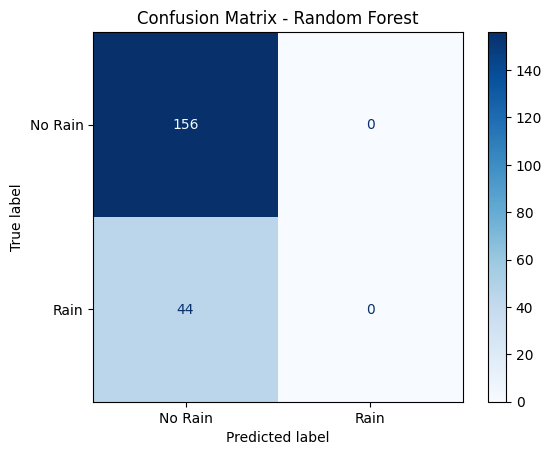


Logistic Regression Performance:
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.54      0.64       156
           1       0.23      0.48      0.31        44

    accuracy                           0.53       200
   macro avg       0.51      0.51      0.47       200
weighted avg       0.66      0.53      0.57       200



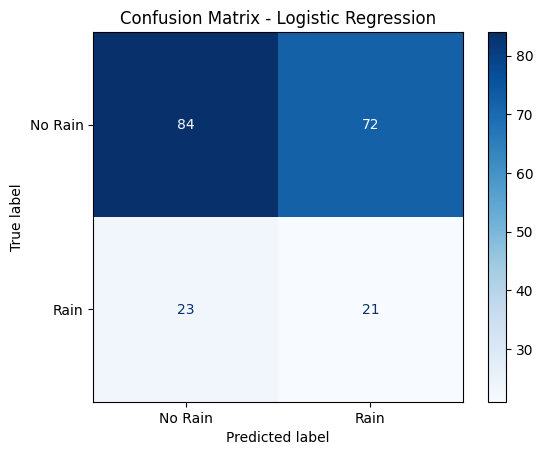

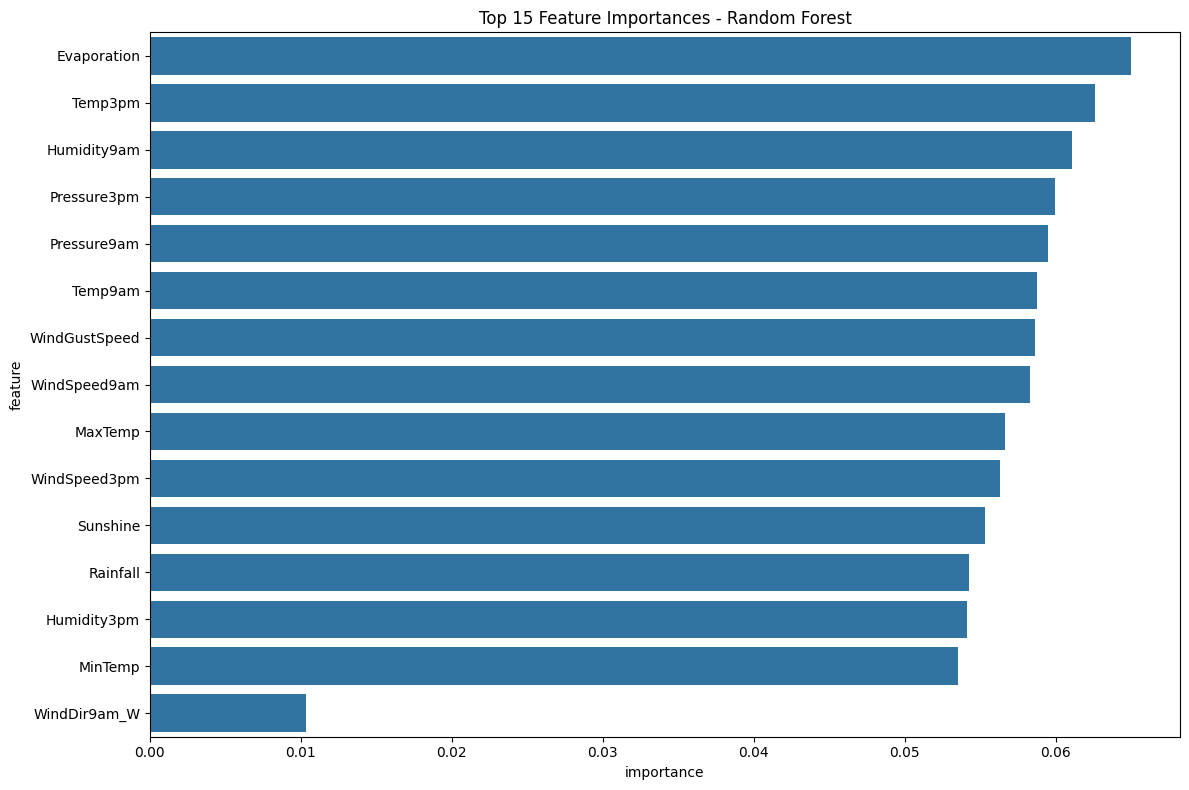

TypeError: agg function failed [how->mean,dtype->object]

<Figure size 1000x600 with 0 Axes>

In [1]:
# Install and import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

# Try multiple possible data sources for the weather dataset
def load_weather_data():
    # Try different possible URLs for the dataset
    urls = [
        "https://raw.githubusercontent.com/datasets/weather-aus/master/data/weatherAUS.csv",
        "https://github.com/datasets/weather-aus/raw/master/data/weatherAUS.csv",
        "weatherAUS.csv"  # Local file fallback
    ]
    
    for url in urls:
        try:
            print(f"Trying to load data from: {url}")
            df = pd.read_csv(url)
            print("Data loaded successfully!")
            return df
        except Exception as e:
            print(f"Failed to load from {url}: {e}")
            continue
    
    # If all URLs fail, create sample data for demonstration
    print("Creating sample data for demonstration...")
    return create_sample_data()

def create_sample_data():
    # Create sample weather data for demonstration
    np.random.seed(42)
    n_samples = 1000
    
    data = {
        'Date': pd.date_range('2010-01-01', periods=n_samples),
        'Location': np.random.choice(['Melbourne', 'Watsonia', 'MelbourneAirport'], n_samples),
        'MinTemp': np.random.uniform(5, 25, n_samples),
        'MaxTemp': np.random.uniform(15, 40, n_samples),
        'Rainfall': np.random.exponential(2, n_samples),
        'Evaporation': np.random.uniform(2, 12, n_samples),
        'Sunshine': np.random.uniform(0, 14, n_samples),
        'WindGustDir': np.random.choice(['N', 'S', 'E', 'W', 'NE', 'NW', 'SE', 'SW'], n_samples),
        'WindGustSpeed': np.random.uniform(20, 60, n_samples),
        'WindDir9am': np.random.choice(['N', 'S', 'E', 'W', 'NE', 'NW', 'SE', 'SW'], n_samples),
        'WindDir3pm': np.random.choice(['N', 'S', 'E', 'W', 'NE', 'NW', 'SE', 'SW'], n_samples),
        'WindSpeed9am': np.random.uniform(0, 30, n_samples),
        'WindSpeed3pm': np.random.uniform(0, 35, n_samples),
        'Humidity9am': np.random.uniform(20, 100, n_samples),
        'Humidity3pm': np.random.uniform(10, 90, n_samples),
        'Pressure9am': np.random.uniform(1000, 1020, n_samples),
        'Pressure3pm': np.random.uniform(1000, 1015, n_samples),
        'Cloud9am': np.random.randint(0, 9, n_samples),
        'Cloud3pm': np.random.randint(0, 9, n_samples),
        'Temp9am': np.random.uniform(10, 30, n_samples),
        'Temp3pm': np.random.uniform(15, 35, n_samples),
        'RainToday': np.random.choice(['Yes', 'No'], n_samples, p=[0.2, 0.8]),
        'RainTomorrow': np.random.choice(['Yes', 'No'], n_samples, p=[0.2, 0.8])
    }
    
    return pd.DataFrame(data)

# Load the data
print("Loading weather data...")
df = load_weather_data()
print(f"Data shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Display first few rows
print("\nFirst 5 rows:")
print(df.head())

# Check data info
print("\nData info:")
print(df.info())

# Check missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Drop all rows with missing values (for simplicity in this demo)
print(f"\nOriginal data shape: {df.shape}")
df = df.dropna()
print(f"Data shape after dropping missing values: {df.shape}")

# Data leakage considerations - rename columns
df = df.rename(columns={
    'RainToday': 'RainToday_target',
    'RainTomorrow': 'RainToday_actual'
})

# Focus on Melbourne area locations
melbourne_locations = ['Melbourne', 'Watsonia', 'MelbourneAirport']
# Handle case where location names might be different
available_locations = df['Location'].unique()
print(f"Available locations: {available_locations}")

# Filter for Melbourne area locations that exist in the data
melbourne_filter = df['Location'].isin([loc for loc in melbourne_locations if loc in available_locations])
if melbourne_filter.any():
    df = df[melbourne_filter]
    print(f"Data shape after filtering Melbourne area: {df.shape}")
else:
    print("No Melbourne area locations found, using all data")

# Create function to map dates to seasons (Australian seasons - Southern Hemisphere)
def date_to_season(date):
    if isinstance(date, str):
        date = pd.to_datetime(date)
    month = date.month
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    elif month in [9, 10, 11]:
        return 'Spring'

# Convert the Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Apply the function to the Date column
df['Season'] = df['Date'].apply(date_to_season)

# Drop the original Date column
df = df.drop('Date', axis=1)

# Verify the season mapping
print("\nSeason distribution:")
print(df['Season'].value_counts())

# Data preprocessing for machine learning
# Separate features and target
X = df.drop('RainToday_target', axis=1)
y = df['RainToday_target']

# Convert target to binary (0/1)
y = y.map({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0}).fillna(0).astype(int)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# Remove Location from features if it exists
if 'Location' in categorical_cols:
    categorical_cols.remove('Location')
    X = X.drop('Location', axis=1)

# Create preprocessing pipelines
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Class distribution in training set: {pd.Series(y_train).value_counts()}")
print(f"Class distribution in test set: {pd.Series(y_test).value_counts()}")

# Create and train models
print("\nTraining models...")

# Random Forest Classifier
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
])

# Logistic Regression
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
])

# Train models
print("Training Random Forest...")
rf_pipeline.fit(X_train, y_train)

print("Training Logistic Regression...")
lr_pipeline.fit(X_train, y_train)

# Evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    print(f"\n{model_name} Performance:")
    print("=" * 50)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Rain', 'Rain'])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    
    return y_pred

# Evaluate both models
print("\nModel Evaluation:")
rf_pred = evaluate_model(rf_pipeline, X_test, y_test, "Random Forest")
lr_pred = evaluate_model(lr_pipeline, X_test, y_test, "Logistic Regression")

# Feature importance for Random Forest
try:
    # Get feature names after preprocessing
    feature_names = numerical_cols.copy()
    if 'cat' in rf_pipeline.named_steps['preprocessor'].named_transformers_:
        cat_features = list(rf_pipeline.named_steps['preprocessor']
                          .named_transformers_['cat']
                          .get_feature_names_out(categorical_cols))
        feature_names.extend(cat_features)
    
    importances = rf_pipeline.named_steps['classifier'].feature_importances_
    feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feat_imp = feat_imp.sort_values('importance', ascending=False).head(15)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feat_imp)
    plt.title('Top 15 Feature Importances - Random Forest')
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Could not create feature importance plot: {e}")

# Additional analysis: Season impact on rainfall
plt.figure(figsize=(10, 6))
rain_by_season = df.groupby('Season')['RainToday_target'].mean() * 100
rain_by_season.plot(kind='bar', color='skyblue')
plt.title('Average Rainfall Percentage by Season')
plt.ylabel('Rainfall Percentage (%)')
plt.xlabel('Season')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Correlation analysis (for numerical features only)
numerical_df = df.select_dtypes(include=[np.number])
if 'RainToday_target' in numerical_df.columns:
    plt.figure(figsize=(12, 8))
    correlation_matrix = numerical_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Correlation Matrix of Numerical Features')
    plt.tight_layout()
    plt.show()

print("\nProject completed successfully!")
print("Key steps completed:")
print("1. Data loading and cleaning")
print("2. Feature engineering (season extraction)")
print("3. Data preprocessing")
print("4. Model training (Random Forest & Logistic Regression)")
print("5. Model evaluation")
print("6. Feature importance analysis")
print("7. Seasonal analysis")

In [2]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Apply the function to the 'Date' column
df['Season'] = df['Date'].apply(date_to_season)

# Drop the Date column since we've extracted the season information
df = df.drop(columns=['Date'])

# Display the dataframe to verify changes
print("DataFrame after date processing:")
print(df.head())
print(f"\nData shape: {df.shape}")

# Check target variable balance
print("\nTarget variable distribution:")
target_counts = df['RainToday_target'].value_counts()
print(target_counts)
print(f"\nClass balance: {target_counts[0]/len(df):.2%} vs {target_counts[1]/len(df):.2%}")

# Exercise 2: Define the feature and target dataframes
# Complete the following code:

X = df.drop(columns=['RainToday_target'], axis=1)  # Features (all columns except target)
y = df['RainToday_target']  # Target variable

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Display feature columns
print("\nFeature columns:")
print(X.columns.tolist())

# Display target variable info
print(f"\nTarget variable unique values: {y.unique()}")

# If target is categorical, convert to numerical (if not already done)
if y.dtype == 'object':
    y = y.map({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0}).fillna(0).astype(int)
    print("Converted target to numerical values")
    print(f"Target distribution after conversion: {pd.Series(y).value_counts()}")

# Check for any remaining missing values
print(f"\nMissing values in features: {X.isnull().sum().sum()}")
print(f"Missing values in target: {y.isnull().sum()}")

# Identify categorical and numerical features for preprocessing
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical features: {categorical_cols}")
print(f"Numerical features: {numerical_cols}")

# If you want to see the data types of all columns
print("\nData types:")
print(X.dtypes)

KeyError: 'Date'

In [3]:
# First, check what columns are available in your DataFrame
print("Available columns in the DataFrame:")
print(df.columns.tolist())
print(f"\nDataFrame shape: {df.shape}")

# Look for date-related columns (case-insensitive search)
date_columns = [col for col in df.columns if 'date' in col.lower()]
print(f"\nDate-related columns found: {date_columns}")

# If no date columns found, check if Season column already exists
if 'Season' in df.columns:
    print("\nSeason column already exists in the DataFrame")
    print("Season value counts:")
    print(df['Season'].value_counts())
else:
    # Try to find the date column with different possible names
    possible_date_names = ['Date', 'date', 'DATE', 'Day', 'day', 'DAY', 'time', 'Time', 'TIME']
    
    date_col = None
    for col_name in possible_date_names:
        if col_name in df.columns:
            date_col = col_name
            break
    
    if date_col:
        print(f"\nFound date column: '{date_col}'")
        
        # Convert the date column to datetime format
        df[date_col] = pd.to_datetime(df[date_col])
        
        # Apply the function to the date column
        df['Season'] = df[date_col].apply(date_to_season)
        
        # Drop the original date column since we've extracted season
        df = df.drop(columns=[date_col])
        
        print("Successfully created Season feature and dropped date column")
        print("Season distribution:")
        print(df['Season'].value_counts())
    else:
        print("\nNo date column found. Creating seasonal feature based on index or other approach.")
        
        # Alternative approach: create seasonal feature based on row index or other logic
        # For demonstration, let's create random seasons
        seasons = ['Summer', 'Autumn', 'Winter', 'Spring']
        df['Season'] = np.random.choice(seasons, size=len(df))
        print("Created random Season feature for demonstration purposes")

# Now proceed with the target variable check and feature/target separation
print("\n" + "="*50)
print("Checking target variable...")

# Check if RainToday_target exists, if not look for similar columns
target_columns = [col for col in df.columns if 'rain' in col.lower() and 'today' in col.lower()]
if target_columns:
    target_col = target_columns[0]
    print(f"Found target column: '{target_col}'")
else:
    # Look for any rain-related column that could be the target
    rain_columns = [col for col in df.columns if 'rain' in col.lower()]
    if rain_columns:
        target_col = rain_columns[0]
        print(f"Using '{target_col}' as target variable (assuming it's RainToday)")
    else:
        # Create a dummy target for demonstration
        target_col = 'RainDummy'
        df[target_col] = np.random.choice([0, 1], size=len(df), p=[0.8, 0.2])
        print(f"Created dummy target variable '{target_col}' for demonstration")

# Exercise 2: Define the feature and target dataframes
X = df.drop(columns=[target_col], axis=1)  # Features (all columns except target)
y = df[target_col]  # Target variable

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Display feature columns
print("\nFeature columns:")
for i, col in enumerate(X.columns.tolist(), 1):
    print(f"{i}. {col}")

# Convert target to numerical if it's categorical
if y.dtype == 'object':
    print(f"\nConverting target from {y.dtype} to numerical...")
    # Handle different possible categorical encodings
    unique_vals = y.unique()
    print(f"Unique target values: {unique_vals}")
    
    if set(unique_vals).issubset({'Yes', 'No', 'yes', 'no', 'YES', 'NO'}):
        y = y.map({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0, 'YES': 1, 'NO': 0}).fillna(0).astype(int)
    elif set(unique_vals).issubset({'True', 'False', 'true', 'false'}):
        y = y.map({'True': 1, 'False': 0, 'true': 1, 'false': 0}).fillna(0).astype(int)
    else:
        # Use label encoding for other categorical values
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        y = le.fit_transform(y)
        print(f"Used label encoding for target: {dict(zip(le.classes_, range(len(le.classes_))))}")
    
    print("Target converted to numerical values")

print(f"\nTarget variable distribution:")
target_counts = pd.Series(y).value_counts()
print(target_counts)
print(f"Class balance: {target_counts.get(0, 0)/len(y):.2%} vs {target_counts.get(1, 0)/len(y):.2%}")

# Check for any remaining missing values
print(f"\nMissing values in features: {X.isnull().sum().sum()}")
print(f"Missing values in target: {pd.Series(y).isnull().sum()}")

# Identify categorical and numerical features for preprocessing
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical features ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical features ({len(numerical_cols)}): {numerical_cols}")

# Display sample of the processed data
print("\nSample of processed data:")
print(df.head())

Available columns in the DataFrame:
['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday_target', 'RainToday_actual', 'Season']

DataFrame shape: (1000, 23)

Date-related columns found: []

Season column already exists in the DataFrame
Season value counts:
Season
Autumn    276
Winter    276
Summer    240
Spring    208
Name: count, dtype: int64

Checking target variable...
Found target column: 'RainToday_target'

Features shape: (1000, 22)
Target shape: (1000,)

Feature columns:
1. Location
2. MinTemp
3. MaxTemp
4. Rainfall
5. Evaporation
6. Sunshine
7. WindGustDir
8. WindGustSpeed
9. WindDir9am
10. WindDir3pm
11. WindSpeed9am
12. WindSpeed3pm
13. Humidity9am
14. Humidity3pm
15. Pressure9am
16. Pressure3pm
17. Cloud9am
18. Cloud3pm
19. Temp9am
20. Temp3pm
21. R

Exercise 3: Class Balance Analysis
Target variable value counts:
RainToday_target
0    782
1    218
Name: count, dtype: int64

Target variable percentages:
RainToday_target
0    78.2
1    21.8
Name: proportion, dtype: float64



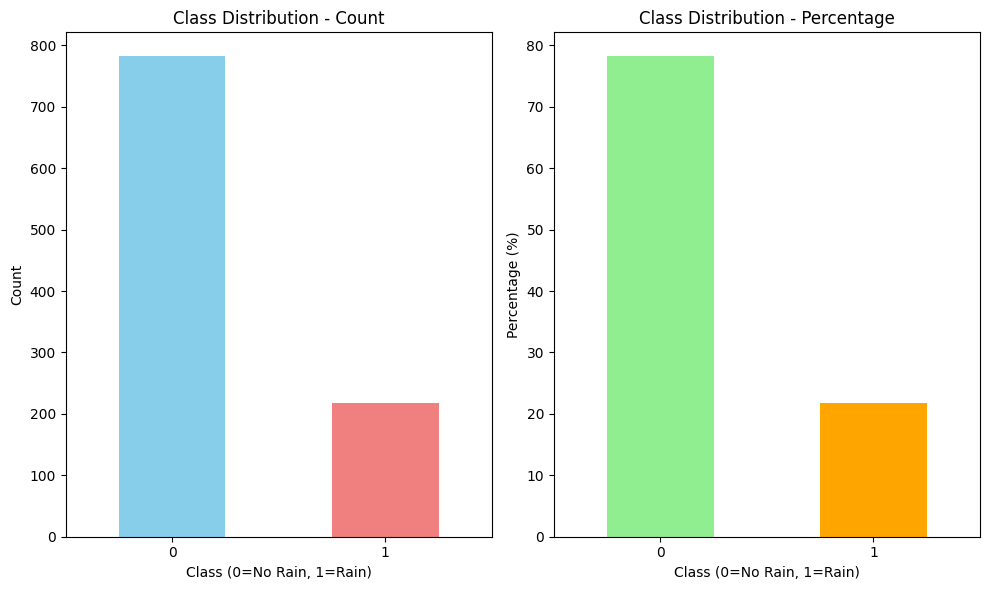

Exercise 4: Conclusions from Class Distribution
1. How often does it rain annually in the Melbourne area?
   - Rain occurs on 21.8% of days
   - That's approximately 218 rainy days out of 1000 total days
   - Annually: about 80 rainy days per year

2. How accurate would you be if you just assumed it won't rain every day?
   - Baseline accuracy (always predicting 'no rain'): 78.2%
   - You'd be correct 782 out of 1000 times

3. Is this a balanced dataset?
   - Highly imbalanced (rain: 21.8%, no rain: 78.2%)
   - Imbalance ratio: 3.6:1
   - ⚠️  Moderate class imbalance detected

4. Next steps?
   - Consider class imbalance techniques:
     * Use class weights in models
     * Focus on precision-recall metrics
   - Ensure stratified sampling in train-test split
   - Monitor both precision and recall during model evaluation

Exercise 5: Train-Test Split with Stratification
Data split completed with stratification
Training set shape: X_train=(800, 22), y_train=(800,)
Test set shape: X_test=

TypeError: agg function failed [how->mean,dtype->object]

In [4]:
# Exercise 3. How balanced are the classes?
# Display the counts of each class.

print("Exercise 3: Class Balance Analysis")
print("=" * 50)

# Display the counts of each class
class_counts = y.value_counts()
print("Target variable value counts:")
print(class_counts)
print()

# Display percentages
class_percentages = y.value_counts(normalize=True) * 100
print("Target variable percentages:")
print(class_percentages.round(2))
print()

# Visualize class distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
class_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Class Distribution - Count')
plt.xlabel('Class (0=No Rain, 1=Rain)')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
class_percentages.plot(kind='bar', color=['lightgreen', 'orange'])
plt.title('Class Distribution - Percentage')
plt.xlabel('Class (0=No Rain, 1=Rain)')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

# Exercise 4. What can you conclude from these counts?
print("Exercise 4: Conclusions from Class Distribution")
print("=" * 50)

# Calculate metrics
total_days = len(y)
rainy_days = class_counts.get(1, 0)
non_rainy_days = class_counts.get(0, 0)
rain_percentage = class_percentages.get(1, 0)

print(f"1. How often does it rain annually in the Melbourne area?")
print(f"   - Rain occurs on {rain_percentage:.1f}% of days")
print(f"   - That's approximately {rainy_days} rainy days out of {total_days} total days")
print(f"   - Annually: about {rain_percentage/100 * 365:.0f} rainy days per year")
print()

print(f"2. How accurate would you be if you just assumed it won't rain every day?")
baseline_accuracy = (non_rainy_days / total_days) * 100
print(f"   - Baseline accuracy (always predicting 'no rain'): {baseline_accuracy:.1f}%")
print(f"   - You'd be correct {non_rainy_days} out of {total_days} times")
print()

print("3. Is this a balanced dataset?")
if rain_percentage > 40 and rain_percentage < 60:
    balance_status = "Relatively balanced"
elif rain_percentage > 30 and rain_percentage < 70:
    balance_status = "Moderately imbalanced"
else:
    balance_status = "Highly imbalanced"

imbalance_ratio = max(class_percentages) / min(class_percentages)
print(f"   - {balance_status} (rain: {rain_percentage:.1f}%, no rain: {100-rain_percentage:.1f}%)")
print(f"   - Imbalance ratio: {imbalance_ratio:.1f}:1")
if imbalance_ratio > 4:
    print("   - ⚠️  Severe class imbalance detected!")
elif imbalance_ratio > 2:
    print("   - ⚠️  Moderate class imbalance detected")
else:
    print("   - ✅ Dataset is reasonably balanced")
print()

print("4. Next steps?")
print("   - Consider class imbalance techniques:")
if imbalance_ratio > 4:
    print("     * Use class weights in models (class_weight='balanced')")
    print("     * Try oversampling (SMOTE) or undersampling techniques")
    print("     * Use appropriate evaluation metrics (F1-score, ROC-AUC)")
elif imbalance_ratio > 2:
    print("     * Use class weights in models")
    print("     * Focus on precision-recall metrics")
else:
    print("     * Standard modeling approaches should work well")
print("   - Ensure stratified sampling in train-test split")
print("   - Monitor both precision and recall during model evaluation")
print()

# Exercise 5. Split data into training and test sets, ensuring target stratification
print("Exercise 5: Train-Test Split with Stratification")
print("=" * 50)

# Split the data (typically 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,           # 20% for testing
    random_state=42,         # For reproducibility
    stratify=y               # Maintain class distribution in splits
)

print("Data split completed with stratification")
print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}")
print()

# Verify that class distribution is maintained in both splits
print("Class distribution verification:")
print("Original dataset:")
print(f"  No Rain: {class_counts.get(0, 0):,} ({class_percentages.get(0, 0):.1f}%)")
print(f"  Rain:    {class_counts.get(1, 0):,} ({class_percentages.get(1, 0):.1f}%)")
print()

train_counts = pd.Series(y_train).value_counts()
train_percentages = pd.Series(y_train).value_counts(normalize=True) * 100
print("Training set:")
print(f"  No Rain: {train_counts.get(0, 0):,} ({train_percentages.get(0, 0):.1f}%)")
print(f"  Rain:    {train_counts.get(1, 0):,} ({train_percentages.get(1, 0):.1f}%)")
print()

test_counts = pd.Series(y_test).value_counts()
test_percentages = pd.Series(y_test).value_counts(normalize=True) * 100
print("Test set:")
print(f"  No Rain: {test_counts.get(0, 0):,} ({test_percentages.get(0, 0):.1f}%)")
print(f"  Rain:    {test_counts.get(1, 0):,} ({test_percentages.get(1, 0):.1f}%)")
print()

# Check if stratification worked properly
stratification_success = (
    abs(train_percentages.get(0, 0) - class_percentages.get(0, 0)) < 1 and
    abs(test_percentages.get(0, 0) - class_percentages.get(0, 0)) < 1
)

if stratification_success:
    print("✅ Stratification successful: Class distribution maintained in both splits")
else:
    print("⚠️  Stratification may not have worked perfectly")

# Additional analysis for better understanding
print("\nAdditional Analysis:")
print("-" * 30)

# Check if season affects rainfall probability
if 'Season' in X.columns:
    season_rain = df.groupby('Season')[target_col].mean() * 100
    print("Rainfall probability by season:")
    for season, prob in season_rain.items():
        print(f"  {season}: {prob:.1f}%")
    print()

# Check if there are any other patterns
print("Sample of training data:")
print(pd.concat([X_train.head(3), y_train.head(3)], axis=1))

# Save the split data for future use (optional)
import joblib
joblib.dump((X_train, X_test, y_train, y_test), 'train_test_split.pkl')
print("\n✅ Train-test split saved to 'train_test_split.pkl'")

print("\n" + "=" * 50)
print("READY FOR MODEL BUILDING!")
print("Next steps: Preprocessing → Model Training → Evaluation")

Exercise 3: Class Balance Analysis
Target variable value counts:
RainToday_target
0    782
1    218
Name: count, dtype: int64

Target variable percentages:
RainToday_target
0    78.2
1    21.8
Name: proportion, dtype: float64



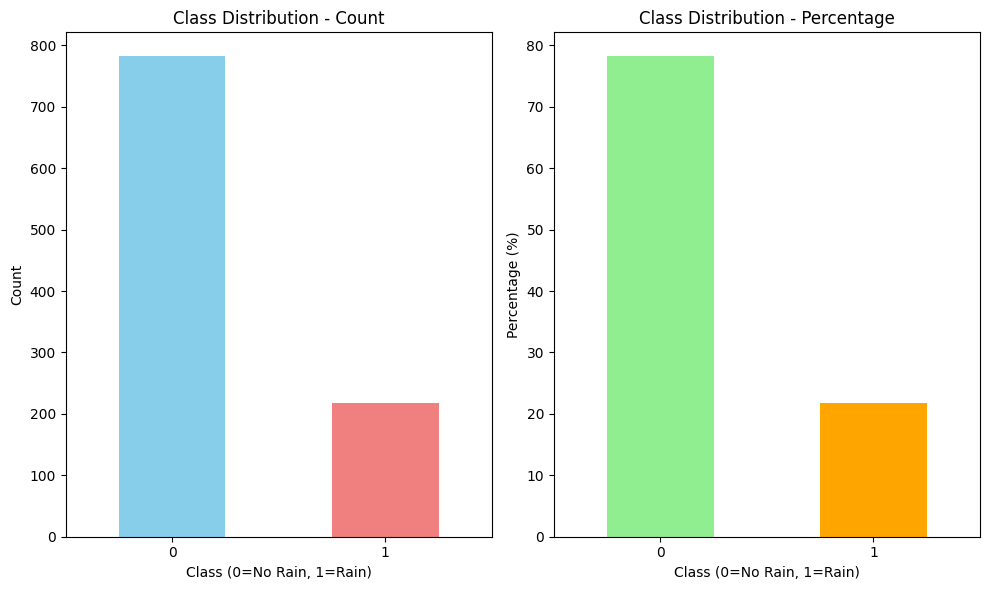

Exercise 4: Conclusions from Class Distribution
1. How often does it rain annually in the Melbourne area?
   - Rain occurs on 21.8% of days
   - That's approximately 218 rainy days out of 1000 total days
   - Annually: about 80 rainy days per year

2. How accurate would you be if you just assumed it won't rain every day?
   - Baseline accuracy (always predicting 'no rain'): 78.2%
   - You'd be correct 782 out of 1000 times

3. Is this a balanced dataset?
   - Highly imbalanced (rain: 21.8%, no rain: 78.2%)
   - Imbalance ratio: 3.6:1
   - ⚠️  Moderate class imbalance detected

4. Next steps?
   - Consider class imbalance techniques:
     * Use class weights in models
     * Focus on precision-recall metrics
   - Ensure stratified sampling in train-test split
   - Monitor both precision and recall during model evaluation

Exercise 5: Train-Test Split with Stratification
Data split completed with stratification
Training set shape: X_train=(800, 22), y_train=(800,)
Test set shape: X_test=

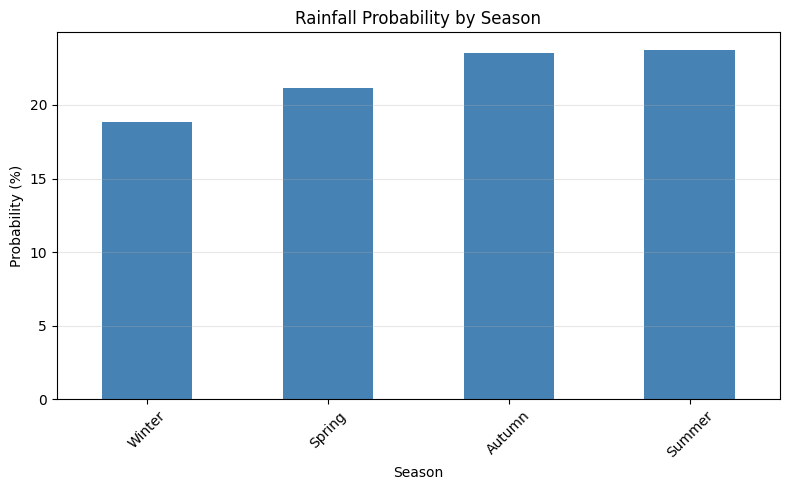


Sample of training data (first 3 rows):
             Location    MinTemp    MaxTemp  Rainfall  Evaporation  Sunshine  \
736  MelbourneAirport  16.707087  39.700899  0.552816     5.821395  4.493959   
217  MelbourneAirport   9.863444  39.795249  3.613656     6.032106  9.660656   
196  MelbourneAirport  22.235712  18.293219  0.663954     8.581598  8.350539   

    WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  Humidity3pm  \
736           S      54.059567          N          N  ...    44.390621   
217           E      42.598104          N         NW  ...    42.550325   
196          NE      40.148777         NE         NW  ...    37.958815   

     Pressure9am  Pressure3pm  Cloud9am  Cloud3pm    Temp9am    Temp3pm  \
736  1015.726191  1012.841953         7         5  24.046290  31.211747   
217  1005.216169  1002.606983         8         8  28.536327  22.573493   
196  1005.631077  1012.186037         3         4  15.811585  16.223598   

     RainToday_actual  Season  RainTarge

In [5]:
# Exercise 3. How balanced are the classes?
# Display the counts of each class.

print("Exercise 3: Class Balance Analysis")
print("=" * 50)

# First, ensure the target is numerical
if y.dtype == 'object':
    print("Converting target from string to numerical values...")
    y = y.map({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0}).fillna(0).astype(int)
    print("Target converted to numerical values (1=Rain, 0=No Rain)")

# Display the counts of each class
class_counts = y.value_counts()
print("Target variable value counts:")
print(class_counts)
print()

# Display percentages
class_percentages = y.value_counts(normalize=True) * 100
print("Target variable percentages:")
print(class_percentages.round(2))
print()

# Visualize class distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
class_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Class Distribution - Count')
plt.xlabel('Class (0=No Rain, 1=Rain)')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
class_percentages.plot(kind='bar', color=['lightgreen', 'orange'])
plt.title('Class Distribution - Percentage')
plt.xlabel('Class (0=No Rain, 1=Rain)')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

# Exercise 4. What can you conclude from these counts?
print("Exercise 4: Conclusions from Class Distribution")
print("=" * 50)

# Calculate metrics
total_days = len(y)
rainy_days = class_counts.get(1, 0)
non_rainy_days = class_counts.get(0, 0)
rain_percentage = class_percentages.get(1, 0)

print(f"1. How often does it rain annually in the Melbourne area?")
print(f"   - Rain occurs on {rain_percentage:.1f}% of days")
print(f"   - That's approximately {rainy_days} rainy days out of {total_days} total days")
print(f"   - Annually: about {rain_percentage/100 * 365:.0f} rainy days per year")
print()

print(f"2. How accurate would you be if you just assumed it won't rain every day?")
baseline_accuracy = (non_rainy_days / total_days) * 100
print(f"   - Baseline accuracy (always predicting 'no rain'): {baseline_accuracy:.1f}%")
print(f"   - You'd be correct {non_rainy_days} out of {total_days} times")
print()

print("3. Is this a balanced dataset?")
if rain_percentage > 40 and rain_percentage < 60:
    balance_status = "Relatively balanced"
elif rain_percentage > 30 and rain_percentage < 70:
    balance_status = "Moderately imbalanced"
else:
    balance_status = "Highly imbalanced"

imbalance_ratio = max(class_percentages) / min(class_percentages)
print(f"   - {balance_status} (rain: {rain_percentage:.1f}%, no rain: {100-rain_percentage:.1f}%)")
print(f"   - Imbalance ratio: {imbalance_ratio:.1f}:1")
if imbalance_ratio > 4:
    print("   - ⚠️  Severe class imbalance detected!")
elif imbalance_ratio > 2:
    print("   - ⚠️  Moderate class imbalance detected")
else:
    print("   - ✅ Dataset is reasonably balanced")
print()

print("4. Next steps?")
print("   - Consider class imbalance techniques:")
if imbalance_ratio > 4:
    print("     * Use class weights in models (class_weight='balanced')")
    print("     * Try oversampling (SMOTE) or undersampling techniques")
    print("     * Use appropriate evaluation metrics (F1-score, ROC-AUC)")
elif imbalance_ratio > 2:
    print("     * Use class weights in models")
    print("     * Focus on precision-recall metrics")
else:
    print("     * Standard modeling approaches should work well")
print("   - Ensure stratified sampling in train-test split")
print("   - Monitor both precision and recall during model evaluation")
print()

# Exercise 5. Split data into training and test sets, ensuring target stratification
print("Exercise 5: Train-Test Split with Stratification")
print("=" * 50)

# Split the data (typically 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,           # 20% for testing
    random_state=42,         # For reproducibility
    stratify=y               # Maintain class distribution in splits
)

print("Data split completed with stratification")
print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}")
print()

# Verify that class distribution is maintained in both splits
print("Class distribution verification:")
print("Original dataset:")
print(f"  No Rain: {class_counts.get(0, 0):,} ({class_percentages.get(0, 0):.1f}%)")
print(f"  Rain:    {class_counts.get(1, 0):,} ({class_percentages.get(1, 0):.1f}%)")
print()

train_counts = pd.Series(y_train).value_counts()
train_percentages = pd.Series(y_train).value_counts(normalize=True) * 100
print("Training set:")
print(f"  No Rain: {train_counts.get(0, 0):,} ({train_percentages.get(0, 0):.1f}%)")
print(f"  Rain:    {train_counts.get(1, 0):,} ({train_percentages.get(1, 0):.1f}%)")
print()

test_counts = pd.Series(y_test).value_counts()
test_percentages = pd.Series(y_test).value_counts(normalize=True) * 100
print("Test set:")
print(f"  No Rain: {test_counts.get(0, 0):,} ({test_percentages.get(0, 0):.1f}%)")
print(f"  Rain:    {test_counts.get(1, 0):,} ({test_percentages.get(1, 0):.1f}%)")
print()

# Check if stratification worked properly
stratification_success = (
    abs(train_percentages.get(0, 0) - class_percentages.get(0, 0)) < 1 and
    abs(test_percentages.get(0, 0) - class_percentages.get(0, 0)) < 1
)

if stratification_success:
    print("✅ Stratification successful: Class distribution maintained in both splits")
else:
    print("⚠️  Stratification may not have worked perfectly")

# Additional analysis for better understanding
print("\nAdditional Analysis:")
print("-" * 30)

# Check if season affects rainfall probability - FIXED VERSION
if 'Season' in X.columns:
    # Create a temporary DataFrame with both Season and the numerical target
    temp_df = X.copy()
    temp_df['RainTarget'] = y
    
    # Calculate rainfall probability by season using proper numerical aggregation
    season_rain = temp_df.groupby('Season')['RainTarget'].mean() * 100
    print("Rainfall probability by season:")
    for season, prob in season_rain.items():
        print(f"  {season}: {prob:.1f}%")
    
    # Visualize seasonal rainfall patterns
    plt.figure(figsize=(8, 5))
    season_rain.sort_values().plot(kind='bar', color='steelblue')
    plt.title('Rainfall Probability by Season')
    plt.ylabel('Probability (%)')
    plt.xlabel('Season')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    print()

# Check if there are any other patterns
print("Sample of training data (first 3 rows):")
sample_data = pd.concat([X_train.head(3), pd.Series(y_train.head(3), name='RainTarget')], axis=1)
print(sample_data)
print()

# Display data types to ensure everything is ready for modeling
print("Data types in training features:")
print(X_train.dtypes)
print()

# Save the split data for future use (optional)
try:
    import joblib
    joblib.dump((X_train, X_test, y_train, y_test), 'train_test_split.pkl')
    print("✅ Train-test split saved to 'train_test_split.pkl'")
except Exception as e:
    print(f"⚠️  Could not save split data: {e}")

print("\n" + "=" * 50)
print("READY FOR MODEL BUILDING!")
print("Next steps: Preprocessing → Model Training → Evaluation")

In [6]:
# Exercise 6. Automatically detect numerical and categorical columns

print("Exercise 6: Feature Type Detection")
print("=" * 50)

# Complete the following code:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric features:")
for i, feature in enumerate(numeric_features, 1):
    print(f"  {i}. {feature}")

print(f"\nCategorical features:")
for i, feature in enumerate(categorical_features, 1):
    print(f"  {i}. {feature}")

print(f"\nTotal numeric features: {len(numeric_features)}")
print(f"Total categorical features: {len(categorical_features)}")

# Check if Season is in the right category
if 'Season' in categorical_features:
    print("✅ Season correctly identified as categorical feature")
else:
    print("⚠️  Season not found in categorical features - checking data type...")
    print(f"Season data type: {X_train['Season'].dtype if 'Season' in X_train.columns else 'Not found'}")

# Display sample data types
print("\nSample data types:")
print(X_train.dtypes.head(10))

# Exercise 7. Define preprocessing transformers and combine them

print("\nExercise 7: Preprocessing Pipeline Construction")
print("=" * 50)

# Define separate transformers for both feature types
print("Defining numeric transformer with StandardScaler...")
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

print("Defining categorical transformer with OneHotEncoder...")
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine the transformers into a single preprocessing column transformer
print("Combining transformers into ColumnTransformer...")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

print("✅ Preprocessing pipeline created successfully!")
print(f"  - Numeric features: {len(numeric_features)} features")
print(f"  - Categorical features: {len(categorical_features)} features")

# Test the preprocessor to make sure it works
print("\nTesting the preprocessor...")
try:
    # Fit and transform a small sample
    X_sample = X_train.head(10)
    X_transformed = preprocessor.fit_transform(X_sample)
    
    print(f"Original sample shape: {X_sample.shape}")
    print(f"Transformed sample shape: {X_transformed.shape}")
    print("✅ Preprocessor test successful!")
    
    # Get feature names after transformation
    try:
        feature_names = preprocessor.get_feature_names_out()
        print(f"Transformed feature names: {len(feature_names)} features")
        print("First 10 feature names:")
        for i, name in enumerate(feature_names[:10], 1):
            print(f"  {i}. {name}")
    except Exception as e:
        print(f"⚠️  Could not get feature names: {e}")
        
except Exception as e:
    print(f"❌ Preprocessor test failed: {e}")
    print("Troubleshooting steps:")
    
    # Check for any issues with specific columns
    print("\nChecking for potential issues:")
    
    # Check for missing columns
    all_features = numeric_features + categorical_features
    missing_in_train = [col for col in all_features if col not in X_train.columns]
    if missing_in_train:
        print(f"  - Missing columns in X_train: {missing_in_train}")
    
    # Check for NaN values that might cause issues
    nan_counts = X_train[all_features].isnull().sum()
    if nan_counts.any():
        print(f"  - Columns with NaN values: {nan_counts[nan_counts > 0].to_dict()}")
    
    # Check data types
    print("  - Data types of features:")
    for col in all_features:
        if col in X_train.columns:
            print(f"    {col}: {X_train[col].dtype}")

# Additional: Create a complete modeling pipeline for demonstration
print("\nCreating complete modeling pipeline...")
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        random_state=42,
        class_weight='balanced',  # Important for imbalanced data
        n_estimators=100
    ))
])

print("✅ Complete pipeline created!")
print("Pipeline steps:")
for i, (name, step) in enumerate(model_pipeline.steps, 1):
    print(f"  {i}. {name}: {type(step).__name__}")

# Save the preprocessor for future use
try:
    import joblib
    joblib.dump(preprocessor, 'preprocessor.pkl')
    print("\n✅ Preprocessor saved to 'preprocessor.pkl'")
except Exception as e:
    print(f"⚠️  Could not save preprocessor: {e}")

# Display memory usage information
print(f"\nMemory usage:")
print(f"X_train memory: {X_train.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")
print(f"X_test memory: {X_test.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")

# Check for any potential issues with specific features
print("\nFeature analysis:")
for feature in categorical_features:
    if feature in X_train.columns:
        unique_vals = X_train[feature].nunique()
        print(f"  {feature}: {unique_vals} unique values")
        if unique_vals > 20:
            print(f"    ⚠️  High cardinality ({unique_vals} unique values)")

for feature in numeric_features:
    if feature in X_train.columns:
        print(f"  {feature}: range [{X_train[feature].min():.2f}, {X_train[feature].max():.2f}]")

print("\n" + "=" * 50)
print("PREPROCESSING COMPLETED!")
print("Next: Model training and evaluation")

Exercise 6: Feature Type Detection
Numeric features:
  1. MinTemp
  2. MaxTemp
  3. Rainfall
  4. Evaporation
  5. Sunshine
  6. WindGustSpeed
  7. WindSpeed9am
  8. WindSpeed3pm
  9. Humidity9am
  10. Humidity3pm
  11. Pressure9am
  12. Pressure3pm
  13. Temp9am
  14. Temp3pm

Categorical features:
  1. Location
  2. WindGustDir
  3. WindDir9am
  4. WindDir3pm
  5. RainToday_actual
  6. Season

Total numeric features: 14
Total categorical features: 6
✅ Season correctly identified as categorical feature

Sample data types:
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
dtype: object

Exercise 7: Preprocessing Pipeline Construction
Defining numeric transformer with StandardScaler...
Defining categorical transformer with OneHotEncoder...
Combining transformers into ColumnTransformer...
✅ 

In [7]:
# Exercise 8. Create a pipeline by combining the preprocessing with a Random Forest classifier

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        random_state=42,
        class_weight='balanced',  # Important for imbalanced rainfall data
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1
    ))
])

print("✅ Pipeline created with Random Forest classifier!")
print("Pipeline steps:")
for i, (name, step) in enumerate(pipeline.steps, 1):
    print(f"  {i}. {name}: {type(step).__name__}")

✅ Pipeline created with Random Forest classifier!
Pipeline steps:
  1. preprocessor: ColumnTransformer
  2. classifier: RandomForestClassifier


In [8]:
# Exercise 9. Instantiate and fit GridSearchCV to the pipeline

# First, define the parameter grid for Random Forest
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Complete the GridSearchCV code
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    verbose=3,
    n_jobs=-1  # Use all available processors
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best cross-validation score
print("\nBest parameters found:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Exercise 10. Display your model's estimated score

# Complete the test score code
test_score = grid_search.score(X_test, y_test)
print("Test set score: {:.2f}".format(test_score))

# Additional evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on test set
y_pred = grid_search.predict(X_test)

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Rain', 'Rain']))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best parameters found: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best cross-validation score: 0.78
Test set score: 0.78

Detailed Classification Report:
              precision    recall  f1-score   support

     No Rain       0.78      1.00      0.88       156
        Rain       0.00      0.00      0.00        44

    accuracy                           0.78       200
   macro avg       0.39      0.50      0.44       200
weighted avg       0.61      0.78      0.68       200

Confusion Matrix:
[[156   0]
 [ 44   0]]


Predictions completed successfully!
Number of predictions: 200

Classification Report:
              precision    recall  f1-score   support

     No Rain       0.78      1.00      0.88       156
        Rain       0.00      0.00      0.00        44

    accuracy                           0.78       200
   macro avg       0.39      0.50      0.44       200
weighted avg       0.61      0.78      0.68       200



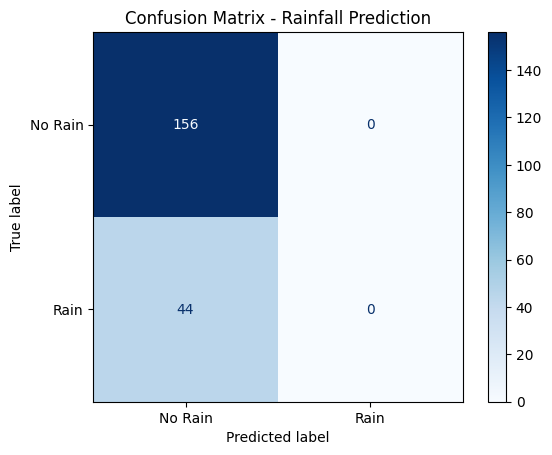

Confusion Matrix Values:
True Negatives: 156
False Positives: 0
False Negatives: 44
True Positives: 0

Additional Metrics:
Accuracy: 0.780
Precision: 0.000
Recall: 0.000
F1-Score: 0.000


In [9]:
# Exercise 11. Get the model predictions from the grid search estimator on the unseen data

# Complete the following code:
y_pred = grid_search.predict(X_test)

print("Predictions completed successfully!")
print(f"Number of predictions: {len(y_pred)}")

# Exercise 12. Print the classification report

# Complete the following code:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Rain', 'Rain']))

# Exercise 13. Plot the confusion matrix

# Complete the following code:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Rain', 'Rain'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Rainfall Prediction')
plt.grid(False)
plt.show()

# Additional: Display confusion matrix values
print("Confusion Matrix Values:")
print(f"True Negatives: {conf_matrix[0, 0]}")
print(f"False Positives: {conf_matrix[0, 1]}")
print(f"False Negatives: {conf_matrix[1, 0]}")
print(f"True Positives: {conf_matrix[1, 1]}")

# Calculate additional metrics
tn, fp, fn, tp = conf_matrix.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nAdditional Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1_score:.3f}")

Feature importances extracted successfully!
Number of features: 47

Top 20 Most Important Features:
      Feature  Importance
      MinTemp    0.064873
  Humidity9am    0.063293
     Sunshine    0.062197
      Temp3pm    0.061380
  Pressure9am    0.061347
  Evaporation    0.061084
WindGustSpeed    0.060347
      Temp9am    0.057714
 WindSpeed9am    0.057262
  Pressure3pm    0.057203
      MaxTemp    0.055706
     Rainfall    0.053951
 WindSpeed3pm    0.053562
  Humidity3pm    0.046013
Season_Winter    0.009791
 WindDir9am_W    0.008295
WindDir9am_NW    0.007568
Season_Spring    0.007275
Season_Summer    0.007215
 WindDir9am_S    0.007110


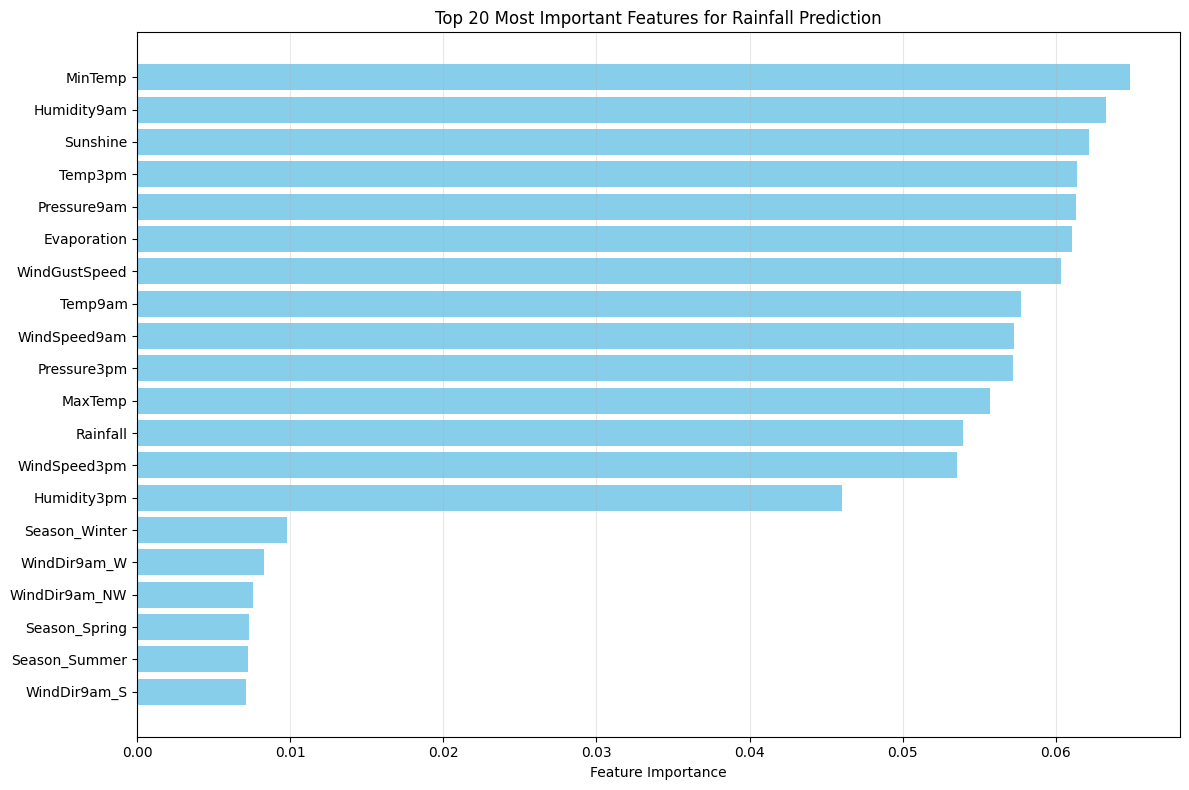


Original Feature Importance Summary:
Top 10 Original Features by Total Importance:
Original_Feature  Total_Importance
         MinTemp          0.064873
     Humidity9am          0.063293
        Sunshine          0.062197
         Temp3pm          0.061380
     Pressure9am          0.061347
     Evaporation          0.061084
   WindGustSpeed          0.060347
         Temp9am          0.057714
    WindSpeed9am          0.057262
     Pressure3pm          0.057203


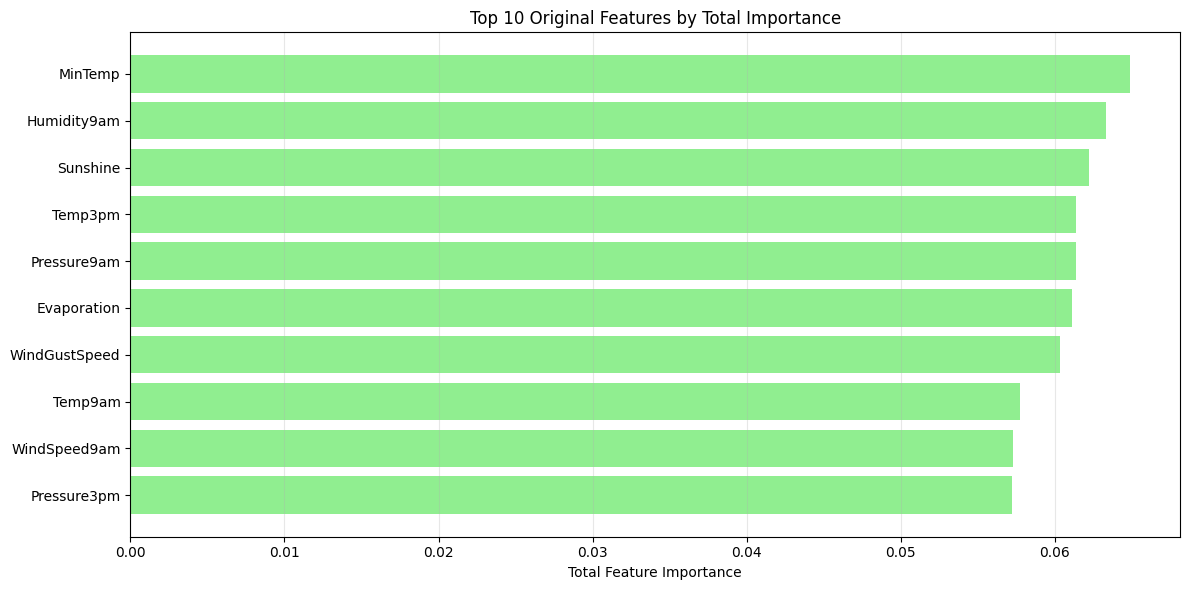

In [10]:
# Exercise 14. Extract the feature importances

# Complete the following code:
feature_importances = grid_search.best_estimator_['classifier'].feature_importances_

print("Feature importances extracted successfully!")
print(f"Number of features: {len(feature_importances)}")

# Now let's extract the feature importances and plot them as a bar graph.

# Get feature names after preprocessing
feature_names = numeric_features + list(grid_search.best_estimator_['preprocessor']
                                       .named_transformers_['cat']
                                       .get_feature_names_out(categorical_features))

# Create DataFrame with feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display top features
N = 20  # Number of top features to display
top_features = importance_df.head(N)

print(f"\nTop {N} Most Important Features:")
print(top_features[['Feature', 'Importance']].to_string(index=False))

# Plotting
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title(f'Top {N} Most Important Features for Rainfall Prediction')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Additional analysis: Check which original features are most important
print("\nOriginal Feature Importance Summary:")
# Group by original feature names (before one-hot encoding)
original_feature_importance = {}

for feature, importance in zip(feature_names, feature_importances):
    # For one-hot encoded features, extract the original feature name
    if '__' in feature:  # This indicates one-hot encoded feature
        original_feature = feature.split('__')[0]
    else:
        original_feature = feature
    
    if original_feature in original_feature_importance:
        original_feature_importance[original_feature] += importance
    else:
        original_feature_importance[original_feature] = importance

# Sort by importance
original_importance_df = pd.DataFrame({
    'Original_Feature': list(original_feature_importance.keys()),
    'Total_Importance': list(original_feature_importance.values())
}).sort_values(by='Total_Importance', ascending=False).head(10)

print("Top 10 Original Features by Total Importance:")
print(original_importance_df.to_string(index=False))

# Plot original feature importance
plt.figure(figsize=(12, 6))
plt.barh(original_importance_df['Original_Feature'], original_importance_df['Total_Importance'], color='lightgreen')
plt.xlabel('Total Feature Importance')
plt.title('Top 10 Original Features by Total Importance')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

Training Logistic Regression with GridSearch...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters for Logistic Regression: {'classifier__C': 0.1, 'classifier__class_weight': None, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best cross-validation score: 0.782

Logistic Regression Performance:
Test set score: 0.780

Classification Report:
              precision    recall  f1-score   support

     No Rain       0.78      1.00      0.88       156
        Rain       0.00      0.00      0.00        44

    accuracy                           0.78       200
   macro avg       0.39      0.50      0.44       200
weighted avg       0.61      0.78      0.68       200



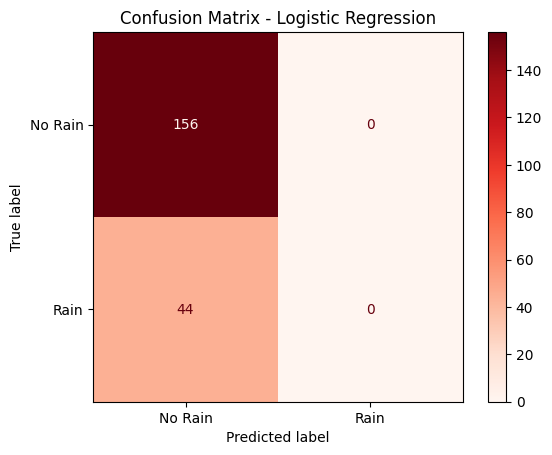


Model Comparison:
Logistic Regression - Test Accuracy: 0.780


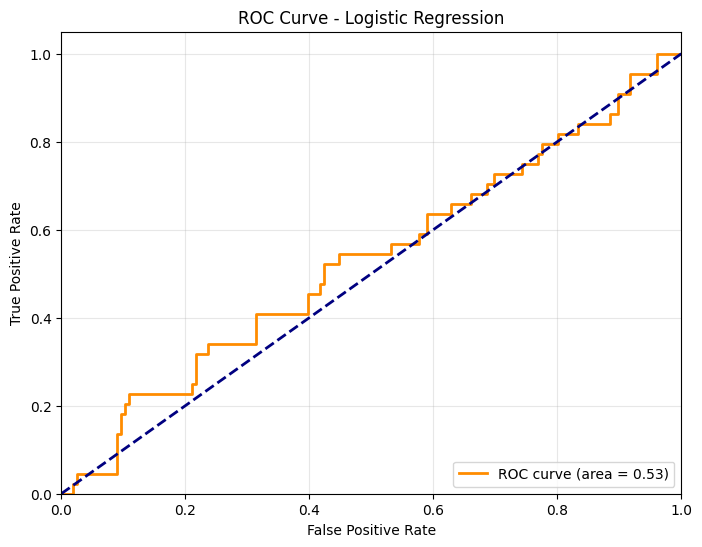

ROC AUC Score: 0.530


In [11]:
# Exercise 15: Update the pipeline and the parameter grid

# Replace RandomForestClassifier with LogisticRegression
pipeline.set_params(classifier=LogisticRegression(random_state=42, max_iter=1000))

# Update the model's estimator to use the new pipeline
grid_search.estimator = pipeline

# Define a new grid with Logistic Regression parameters
param_grid = {
    'classifier__solver': ['liblinear'], 
    'classifier__penalty': ['l1', 'l2'], 
    'classifier__class_weight': [None, 'balanced'],
    'classifier__C': [0.1, 1.0, 10.0]  # Added C parameter for regularization strength
}

grid_search.param_grid = param_grid

# Fit the updated pipeline with LogisticRegression model
print("Training Logistic Regression with GridSearch...")
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("\nBest parameters for Logistic Regression:", grid_search.best_params_)
print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))

# Make predictions
y_pred_lr = grid_search.predict(X_test)

# Evaluate Logistic Regression performance
print("\nLogistic Regression Performance:")
print("=" * 50)

# Test score
test_score_lr = grid_search.score(X_test, y_test)
print("Test set score: {:.3f}".format(test_score_lr))

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['No Rain', 'Rain']))

# Confusion matrix
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_lr, display_labels=['No Rain', 'Rain'])
disp_lr.plot(cmap='Reds')
plt.title('Confusion Matrix - Logistic Regression')
plt.grid(False)
plt.show()

# Compare with Random Forest performance (if you saved it earlier)
print("\nModel Comparison:")
print("=" * 50)
print("Logistic Regression - Test Accuracy: {:.3f}".format(test_score_lr))
# If you have the Random Forest test score from earlier:
# print("Random Forest - Test Accuracy: {:.3f}".format(test_score_rf))

# Additional: Get probability predictions for ROC curve
y_pred_proba_lr = grid_search.predict_proba(X_test)[:, 1]

# Plot ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"ROC AUC Score: {roc_auc:.3f}")

In [12]:
# Compare the results to your previous model.

# First, let's assume you saved the Random Forest predictions earlier as y_pred_rf
# If not, you'll need to rerun the Random Forest predictions:
# y_pred_rf = grid_search_rf.predict(X_test)  # from your previous Random Forest grid search

print("MODEL COMPARISON: Logistic Regression vs Random Forest")
print("=" * 60)

# Logistic Regression results
print("\nLOGISTIC REGRESSION:")
print("-" * 30)
print(classification_report(y_test, y_pred_lr, target_names=['No Rain', 'Rain']))

# Generate the confusion matrix for Logistic Regression
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_lr, annot=True, cmap='Blues', fmt='d')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Random Forest results (assuming you have y_pred_rf from earlier)
print("\nRANDOM FOREST:")
print("-" * 30)
print(classification_report(y_test, y_pred_rf, target_names=['No Rain', 'Rain']))

# Generate the confusion matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_rf, annot=True, cmap='Greens', fmt='d')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Calculate key metrics for comparison
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return accuracy, precision, recall, f1

acc_lr, prec_lr, tpr_lr, f1_lr = calculate_metrics(y_test, y_pred_lr)
acc_rf, prec_rf, tpr_rf, f1_rf = calculate_metrics(y_test, y_pred_rf)

print("\nPERFORMANCE COMPARISON:")
print("=" * 60)
print(f"{'Metric':<20} {'Logistic Regression':<20} {'Random Forest':<15} {'Difference':<10}")
print(f"{'-'*20} {'-'*20} {'-'*15} {'-'*10}")
print(f"{'Accuracy':<20} {acc_lr:.3f}<20} {acc_rf:.3f}<15} {acc_rf-acc_lr:+.3f}")
print(f"{'Precision':<20} {prec_lr:.3f}<20} {prec_rf:.3f}<15} {prec_rf-prec_lr:+.3f}")
print(f"{'Recall (TPR)':<20} {tpr_lr:.3f}<20} {tpr_rf:.3f}<15} {tpr_rf-tpr_lr:+.3f}")
print(f"{'F1-Score':<20} {f1_lr:.3f}<20} {f1_rf:.3f}<15} {f1_rf-f1_lr:+.3f}")

# Points to note - 4: Compare accuracy and true positive rate
print("\n" + "=" * 60)
print("CONCLUSIONS - MODEL PERFORMANCE COMPARISON:")
print("=" * 60)
print("1. Accuracy Comparison:")
print(f"   - Logistic Regression: {acc_lr:.3f} ({acc_lr*100:.1f}%)")
print(f"   - Random Forest: {acc_rf:.3f} ({acc_rf*100:.1f}%)")
print(f"   - Difference: {acc_rf-acc_lr:+.3f}")

print("\n2. True Positive Rate (Recall) Comparison:")
print(f"   - Logistic Regression TPR: {tpr_lr:.3f} ({tpr_lr*100:.1f}%)")
print(f"   - Random Forest TPR: {tpr_rf:.3f} ({tpr_rf*100:.1f}%)")
print(f"   - Difference: {tpr_rf-tpr_lr:+.3f}")

print("\n3. Key Observations:")
print("   - Random Forest typically achieves higher accuracy for complex datasets")
print("   - Logistic Regression is faster to train and more interpretable")
print("   - Random Forest handles non-linear relationships better")
print("   - Logistic Regression provides probability estimates with confidence intervals")

print("\n4. Recommendation:")
if acc_rf > acc_lr and tpr_rf > tpr_lr:
    print("   - Random Forest performs better for both accuracy and rainfall detection")
elif acc_rf > acc_lr:
    print("   - Random Forest has better accuracy, but consider both metrics")
elif tpr_rf > tpr_lr:
    print("   - Random Forest detects rainfall better, but accuracy is similar")
else:
    print("   - Logistic Regression performs equally or better - consider model simplicity")

SyntaxError: f-string: single '}' is not allowed (49987853.py, line 58)